In [122]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pybedtools as pbt
import math

In [123]:
wd = "/Genomics/kocherlab/bjarnold/Nmel"

stpeaker_peaks_file = f"{wd}/starrpeaker_test/chr1/Nmel-F1.peak.final.bed"
# Column 1: Chromosome
# Column 2: Start position
# Column 3: End position
# Column 4: Name (peak rank based on score, 1 being the highest rank)
# Column 5: Score (integer value of "100 * fold change", maxed at 1000 per BED format specification)
# Column 6: Strand
# Column 7: Log2 Fold change (normalized output/input ratio, in log2 space)
# Column 8: Input fragment coverage (total fragments across/within replicate(s))
# Column 9: Output fragment coverage (total fragments across/within replicate(s))
# Column 10: -log10 of P-value
# Column 11: -log10 of Q-value (Benjamini-Hochberg False Discovery Rate, FDR)
stpeaker_raw_file = f"{wd}/starrpeaker_test/chr1/Nmel-F1.peak.bed"

macs_peaks_file = f"{wd}/MACS2/Nmel-F1_peaks.narrowPeak" 
# 1. chromosome
# 2. start
# 3. end
# 4. name
# 5. score
# 6. strand
# 7. signalValue - measurement of overall enrichment for the region
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - Point-source called for this peak; -based offset from chromStart

genrich_peaks_file = f"{wd}/genrich_single/Nmel-F1_peaks.narrowPeak"
# 1. chromosome
# 2. chromStart
# 3. chromEnd
# 4. name
# 5. score
# 6. strand
# 7. signalValue - total area under the curve (AUC)
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - summit position (0-based offset from chromStart)


In [124]:
df = pd.read_csv(stpeaker_peaks_file, sep="\t", header=None)
df.columns = ["chromosome", "start", "end", "name_s", "score_s", "strand_s", "log2FC_s", "input_s", "output_s", "pValue_s", "qValue_s"]
df['fold_change'] = 2**df['log2FC_s']
df['midpoint'] = (df['end'] - df['start']) + df['start']

raw_df = pd.read_csv(stpeaker_raw_file, sep="\t", header=None)
raw_df['midpoint'] = (raw_df[2] - raw_df[1]) + raw_df[1]


In [125]:
sig_df = df[df["qValue_s"] > 1] # 1.3 corresponds to pvalue of 0.05
# sig_df = df[df["fold_change"] > 3] # 1.3 corresponds to pvalue of 0.05
print(len(sig_df))


290


### Minimum coverage of 10 by default, so some 250bp intervals will be excluded

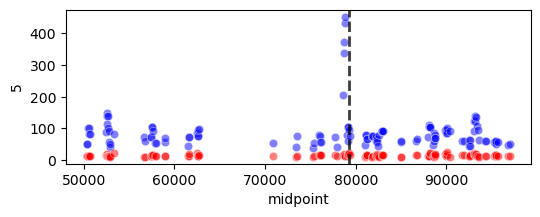

In [126]:
lowerb = 50000
upperb = 100000

sig_df_subset = sig_df[(sig_df['midpoint'] > lowerb) &( sig_df['midpoint'] < upperb)]
raw_df_subset = raw_df[(raw_df['midpoint'] > lowerb) &( raw_df['midpoint'] < upperb)]

fig, axs = plt.subplots(1, 1, figsize=(6, 2), sharex=True)
# plot raw experimental and control data
sns.scatterplot(data=raw_df_subset, x="midpoint", y=5, alpha=0.5, color="blue")
sns.scatterplot(data=raw_df_subset, x="midpoint", y=4, alpha=0.5, color="red")
# plot pileup fold difference

# make verrtical lines for peaks according to macs_df['peak_coord_m'] coordinates
for i in sig_df_subset['midpoint']:
    plt.axvline(x=i, color='black', linestyle='--', alpha=0.5, linewidth=2)
    plt.axvline(x=i, color='black', linestyle='--', alpha=0.5, linewidth=2)
    
# axs[1].axhline(y=1, color='black', linestyle='--', alpha=0.5, linewidth=2)



In [127]:
macs_df = pd.read_csv(macs_peaks_file, sep="\t", header=None)
macs_df.columns = ["chromosome", "start", "end", "name_m", "score_m", "strand_m", "signalValue_m", "pValue_m", "qValue_m", "peak_m"]
macs_df = macs_df.sort_values(by=["chromosome","start"])
macs_df["peak_coord_m"] = macs_df["peak_m"] + macs_df["start"]

genrich_df = pd.read_csv(genrich_peaks_file, sep="\t", header=None)
genrich_df.columns = ["chromosome", "start", "end", "name_g", "score_g", "strand_g", "signalValue_g", "pValue_g", "qValue_g", "peak_g"]
genrich_df = genrich_df.sort_values(by=["chromosome","start"])
genrich_df["peak_coord_g"] = genrich_df["peak_g"] + genrich_df["start"]

# FILTER FOR SIGNIFICANCE

# log_qval = 6 # 1.3 corresponds to qvalue of 0.05
macs_df = macs_df[macs_df["qValue_m"] > 2] # 1.3 corresponds to pvalue of 0.05
macs_df = macs_df[macs_df["signalValue_m"] > 3] 
print(len(macs_df))

genrich_df = genrich_df[genrich_df["qValue_g"] > 2.5] # 1.3 corresponds to pvalue of 0.05
genrich_df = genrich_df[genrich_df["signalValue_g"] > 400]
print(len(genrich_df))

# FILTER FOR CHROMOSOME 1
macs_df = macs_df[macs_df["chromosome"] == "NMEL_chr_1"]
genrich_df = genrich_df[genrich_df["chromosome"] == "NMEL_chr_1"]

macs_subset = macs_df[(macs_df['peak_coord_m'] > lowerb) &( macs_df['peak_coord_m'] < upperb)]
genrich_subset = genrich_df[(genrich_df['peak_coord_g'] > lowerb) &( genrich_df['peak_coord_g'] < upperb)]

11936
12088


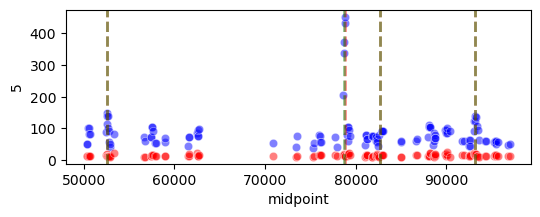

In [130]:
fig, axs = plt.subplots(1, 1, figsize=(6, 2), sharex=True)
# plot raw experimental and control data
sns.scatterplot(data=raw_df_subset, x="midpoint", y=5, alpha=0.5, color="blue")
sns.scatterplot(data=raw_df_subset, x="midpoint", y=4, alpha=0.5, color="red")

for i in macs_subset['peak_coord_m']:
    plt.axvline(x=i, color='red', linestyle='--', alpha=0.25, linewidth=2)
    plt.axvline(x=i, color='red', linestyle='--', alpha=0.25, linewidth=2)
for i in genrich_subset['peak_coord_g']:
    plt.axvline(x=i, color='green', linestyle='--', alpha=0.25, linewidth=2)
    plt.axvline(x=i, color='green', linestyle='--', alpha=0.25, linewidth=2)